# scrapers

> This module contains multiple scrapers, mostly for NSE

In [ ]:
# | default_exp experiments

In [ ]:

import pandas as pd
import numpy as np
import nbdev

from math import pi

from scipy.signal import butter, filtfilt
import numpy as np
import talib
import matplotlib.pyplot as plt

In [ ]:
# | export
base_path = nbdev.config.get_config().lib_path

In [ ]:
# | export
processed_data_dir = base_path / "../Data/Bhavcopy/Processed/"

In [ ]:
def get_symbol_data(symbol):
    file_path = base_path / processed_data_dir / f"{symbol}.parquet"
    return (
        (pd.read_parquet(file_path).assign(DATE=lambda x:x.DATE.astype("datetime64[ns]")))
        if file_path.exists()
        else None
    )

## Hurst Exponent

Use the Hurst exponent for strategy selection
The Hurst exponent ranges between 0 and 1.

If the Hurst exponent is below 0.5, the market is mean reverting. Reversal strategies win in these markets.

If the Hurst exponent of 0.5 means the market is random. In this case, a trading strategy that relies on the market direction will lose money.

If the Hurst exponent is above 0.5 the market is trending. Markets with a high Hurst exponent are perfect for trend-following strategies.

In [ ]:
def get_hurst_exponent(ts, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    
    # variances of the lagged differences
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    
    # calculate the slope of the log plot -> the Hurst Exponent
    return np.polyfit(np.log(lags), np.log(tau), 1)[0]

In [ ]:
df = get_symbol_data("CIPLA")

# Filter for dates after 2019
# df = df.query("DATE >= '2023-01-01'")

df = df.drop(
    columns=[
        x
        for x in df.columns
        if x
        not in [
            "DATE",
            "CLOSE",
        ]
    ]
)

In [ ]:
# Calculate daily log return
df["log_return"] = df.CLOSE.apply(np.log).diff(1)

# Hilbert Transform - Dominant Cycle Phase
df["phase"] = talib.HT_DCPHASE(df.CLOSE)

# Convert into a wave using a cycle model
df["signal"] = np.sin(df.phase + pi / 4)

# Use the Hilbert Transform - Dominant Cycle Period
df["period"] = talib.HT_DCPERIOD(df.CLOSE)

In [ ]:
def butter_bandpass(data, period, delta=0.5, fs=5):
    nyq = 0.5 * fs

    # Low cutoff frequency
    low = 1.0 / (period * (1 + delta))
    low /= nyq

    # High cutoff frequency
    high = 1.0 / (period * (1 - delta))
    high /= nyq

    b, a = butter(2, [low, high], btype="band")

    return filtfilt(b, a, data)

def roll_apply(e):
    close = df.CLOSE.loc[e.index]
    period = df.period.loc[e.index].iloc[-1]
    out = butter_bandpass(close, period)
    return out[-1]

In [ ]:
df["filtered"] = (
    df.dropna()
    .rolling(window=30)
    .apply(lambda series: roll_apply(series), raw=False)
    .iloc[:, 0]
)

df["amplitude"] = df.filtered.rolling(window=30).apply(
    lambda series: series.max() - series.min()
)

df["ema_amplitude"] = talib.EMA(df.amplitude, timeperiod=30)

C:\Users\ankur\AppData\Local\Temp\ipykernel_14344\2767274099.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['DATE'], dtype='object')
  df.dropna()


In [ ]:
df

,CLOSE,DATE,log_return,phase,signal,period,filtered,amplitude,ema_amplitude
0,655.35,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,645.65,2016-01-04,-0.014912,NaN,NaN,NaN,NaN,NaN,NaN
2,640.85,2016-01-05,-0.007462,NaN,NaN,NaN,NaN,NaN,NaN
3,652.10,2016-01-06,0.017403,NaN,NaN,NaN,NaN,NaN,NaN
4,637.45,2016-01-07,-0.022722,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1847,989.40,2023-06-23,-0.008955,185.606856,-0.861536,25.348151,1.864264,8.622213,8.505403
1848,1021.90,2023-06-26,0.032320,183.296114,0.955825,25.475322,-0.093206,8.622213,8.512939
1849,1009.25,2023-06-27,-0.012456,182.089571,0.615165,25.000051,0.777239,8.622213,8.519989
1850,1009.90,2023-06-28,0.000644,180.808502,-0.579792,24.158135,2.352497,8.622213,8.526584


In [ ]:
signal_thresh = 0.75
amp_thresh = 0.004  # 40 pips

df["position"] = 0
df.loc[(df.signal >= signal_thresh) & (df.amplitude > amp_thresh), "position"] = -1
df.loc[(df.signal <= -signal_thresh) & (df.amplitude > amp_thresh), "position"] = 1

In [ ]:
# df2 = df
# # df = df2[-200:]
# df.shape

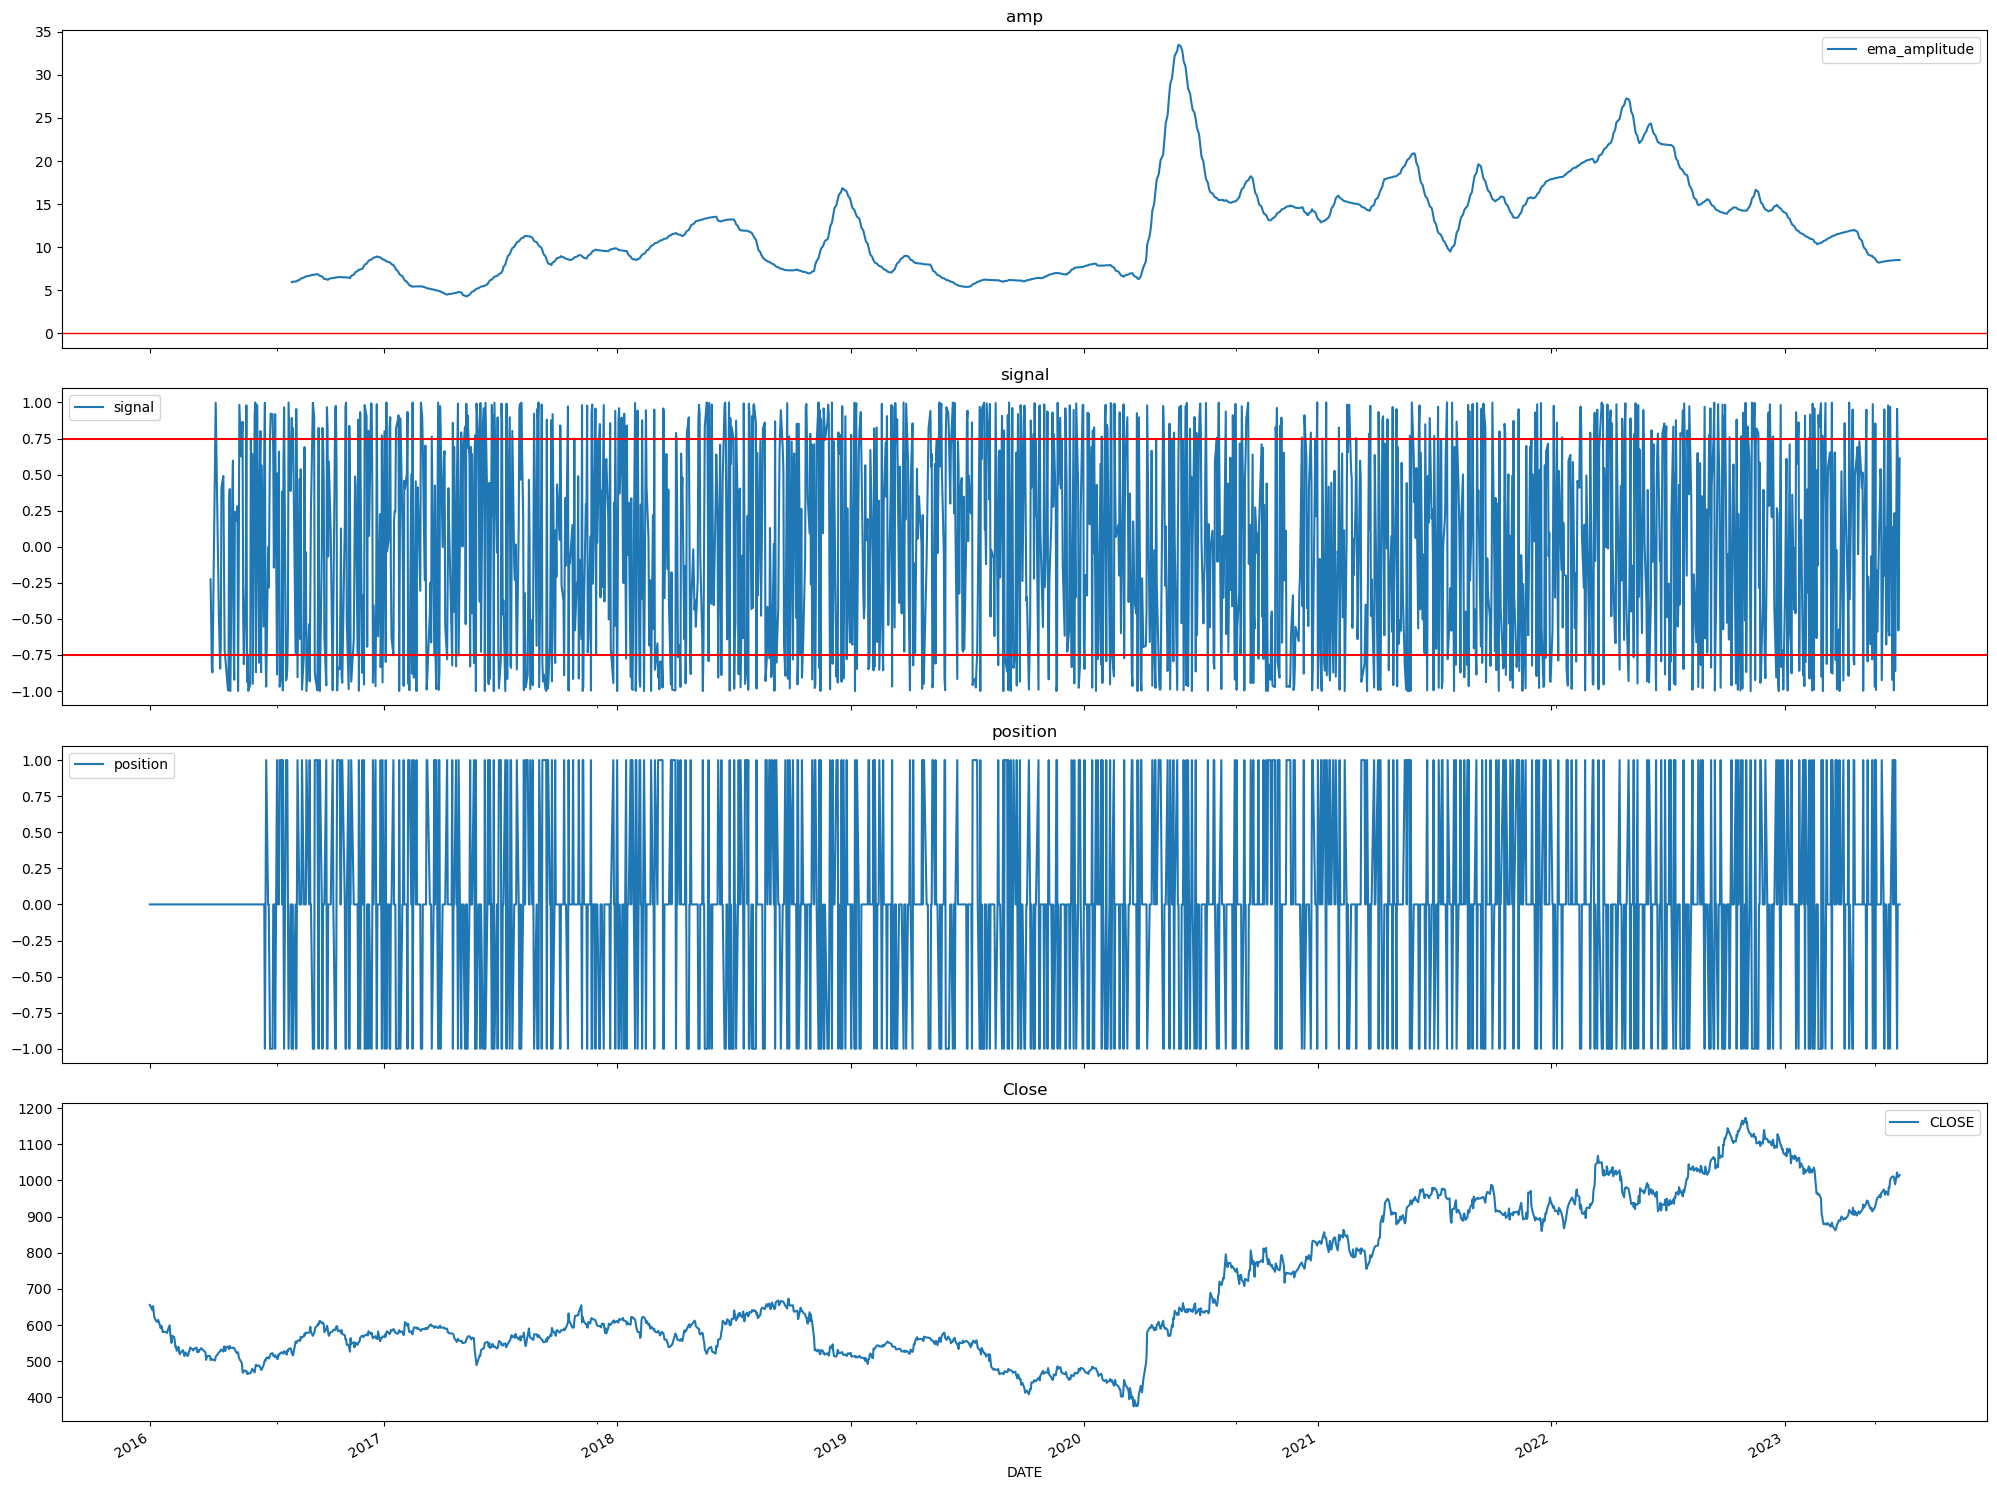

In [ ]:
fig, axes = plt.subplots(
    nrows=4,
    figsize=(20, 15),
    sharex=True
)

df.plot(
    x="DATE",
    y = 'ema_amplitude',
    ax=axes[0],
    title="amp"
)
axes[0].axhline(
    amp_thresh,
    lw=1,
    c="r"
)
df.plot(
    x='DATE',
    y = 'signal',
    ax=axes[1],
    title="signal",
)
axes[1].axhline(
    signal_thresh,
    c="r"
)
axes[1].axhline(
    -signal_thresh,
    c="r"
)
df.plot(
    x='DATE',
    y='position',
    ax=axes[2],
    title="position"
)
df.plot(
    x='DATE',
    y='CLOSE',
    ax=axes[3],
    title="Close"
)
fig.tight_layout()

In [ ]:

# for lag in [20, 50, 100, 250, 500, 1000]:
#     try:
#         hurst_exp = get_hurst_exponent(df.CLOSE.to_list(), lag)
#         print(f"{lag} lags: {hurst_exp:.4f}")
#     except Exception:
#         print(f"{lag} lags: NaN")

In [ ]:
# df.plot(x="DATE", y=["CLOSE", "SMA_20_C"], figsize=(20, 5))

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()